# Uproot and Awkward Arrays

## Tutorial for Electron Ion Collider users

Jim Pivarski (Princeton University)

In [1]:
import os
os.chdir("..")

## Table of contents

* [Uproot: getting data](#uproot)
    - [Exploring a TFile](#Exploring-a-TFile)
    - [Exploring a TTree](#Exploring-a-TTree)
    - [Turning ROOT branches into NumPy arrays](#Turning-ROOT-branches-into-NumPy-arrays)
    - [Memory management; caching and iteration](#Memory-management;-caching-and-iteration)
    - [Jagged arrays (segue)](#Jagged-arrays-(segue))
* [Awkward Array: manipulating data](#awkward)
    - [Using Uproot data in Awkward 1.0](#Using-Uproot-data-in-Awkward-1.0)
    - [Iteration in Python vs array-at-a-time operations](#Iteration-in-Python-vs-array-at-a-time-operations)
    - [Zipping arrays into records and projecting them back out](#Zipping-arrays-into-records-and-projecting-them-back-out)
    - [Filtering (cutting) events and particles with advanced selections](#Filtering-(cutting)-events-and-particles-with-advanced-selections)
    - [Flattening for plots and regularizing to NumPy for machine learning](#Flattening-for-plots-and-regularizing-to-NumPy-for-machine-learning)
    - [Broadcasting flat arrays and jagged arrays](#Broadcasting-flat-arrays-and-jagged-arrays)
    - [Combinatorics: cartesian and combinations](#Combinatorics:-cartesian-and-combinations)
    - [Reducing from combinations](#Reducing-from-combinations)
    - [Imperative, but still fast, programming in Numba](#Imperative,-but-still-fast,-programming-in-Numba)
    - [Grafting jagged data onto Pandas](#Grafting-jagged-data-onto-Pandas)
    - [NumExpr, Autograd, and other third-party libraries](#NumExpr,-Autograd,-and-other-third-party-libraries)

<br>
<br>
<a name="uproot"></a>
<img src="https://github.com/scikit-hep/uproot/raw/master/docs/source/logo-600px.png" width="300">

Uproot is a pure Python reimplementation of a significant part of ROOT I/O.

<br>
<img src="https://raw.githubusercontent.com/jpivarski/2019-07-29-dpf-python/master/img/abstraction-layers.png" width="700">
<br>

You can read TTrees containing basic data types, STL vectors, strings, and some more complex data, especially if it was written with a high "splitLevel".

You can also read histograms and other objects into generic containers, but the C++ methods that give those objects functionality are not available.

## Exploring a TFile

Uproot was designed to be Pythonic, so the way we interact with ROOT files is different than it is in ROOT.

In [2]:
import uproot
file = uproot.open("docs-demo-notebooks/open_charm_18x275_10k.root")

A ROOT file may be thought of as a dict of key-value pairs, like a Python dict.

In [3]:
file.keys()

[b'events;1']

In [4]:
file.values()

[<ROOTDirectory b'events' at 0x7f2dde114d90>]

**What's the `b` before the name?** All strings retrieved from ROOT are unencoded, which Python 3 treats differently from Python 2. In the near future, Uproot will automatically interpret all strings from ROOT as UTF-8 and this cosmetic issue will be gone.

**What's the `;1` at the end of the name?** It's the cycle number, something ROOT uses to track multiple versions of an object. You can usually ignore it.

Nested directories are a dict of dicts.

In [5]:
file["events"].keys()

[b'tree;2', b'tree;1']

In [6]:
file["events"]["tree"]

<TTree b'tree' at 0x7f2dde125e90>

But there are shortcuts:

   * use a `/` to navigate through the levels in a single string;
   * use `allkeys` to recursively show all keys in all directories.

In [7]:
file.allkeys()

[b'events;1', b'events/tree;2', b'events/tree;1']

In [8]:
file["events/tree"]

<TTree b'tree' at 0x7f2dde125cd0>

## Exploring a TTree

A TTree can also be thought of as a dict of dicts, this time to navigate through TBranches.

In [3]:
tree = file["events/tree"]
tree.keys()

[b'evt_id',
 b'evt_true_q2',
 b'evt_true_x',
 b'evt_true_y',
 b'evt_true_w2',
 b'evt_true_nu',
 b'evt_has_dis_info',
 b'evt_prt_count',
 b'evt_weight',
 b'id',
 b'pdg',
 b'trk_id',
 b'charge',
 b'dir_x',
 b'dir_y',
 b'dir_z',
 b'p',
 b'px',
 b'py',
 b'pz',
 b'tot_e',
 b'm',
 b'time',
 b'is_beam',
 b'is_stable',
 b'gen_code',
 b'mother_id',
 b'mother_second_id',
 b'has_pol_info',
 b'pol_x',
 b'pol_y',
 b'pol_z',
 b'has_vtx_info',
 b'vtx_id',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'vtx_t',
 b'has_smear_info',
 b'smear_has_e',
 b'smear_has_p',
 b'smear_has_pid',
 b'smear_has_vtx',
 b'smear_has_any_eppid',
 b'smear_orig_tot_e',
 b'smear_orig_p',
 b'smear_orig_px',
 b'smear_orig_py',
 b'smear_orig_pz',
 b'smear_orig_vtx_x',
 b'smear_orig_vtx_y',
 b'smear_orig_vtx_z']

Often, the first thing I do when I look at a TTree is `show` to see how each branch is going to be interpreted.

In [10]:
print("branch name              streamer (for complex data)  interpretation in Python")
print("==============================================================================")

tree.show()

branch name              streamer (for complex data)  interpretation in Python
evt_id                     (no streamer)              asdtype('>u8')
evt_true_q2                (no streamer)              asdtype('>f8')
evt_true_x                 (no streamer)              asdtype('>f8')
evt_true_y                 (no streamer)              asdtype('>f8')
evt_true_w2                (no streamer)              asdtype('>f8')
evt_true_nu                (no streamer)              asdtype('>f8')
evt_has_dis_info           (no streamer)              asdtype('int8')
evt_prt_count              (no streamer)              asdtype('>u8')
evt_weight                 (no streamer)              asdtype('>f8')
id                         (no streamer)              asjagged(asdtype('>u8'))
pdg                        (no streamer)              asjagged(asdtype('>i8'))
trk_id                     (no streamer)              asjagged(asdtype('>f8'))
charge                     (no streamer)              asjagged

Most of the information you'd expect to find in a TTree is there. See [uproot.readthedocs.io](https://uproot.readthedocs.io/en/latest/ttree-handling.html) for a complete list.

In [11]:
tree.numentries

10000

In [12]:
tree["evt_id"].compressedbytes(), tree["evt_id"].uncompressedbytes(), tree["evt_id"].compressionratio()

(15417, 80000, 5.189076992929882)

In [13]:
tree["evt_id"].numbaskets

3

In [14]:
[tree["evt_id"].basket_entrystart(i) for i in range(3)]

[0, 3990, 5883]

## Turning ROOT branches into NumPy arrays

There are several methods for this; they differ only in convenience.

In [15]:
# TBranch → array
tree["evt_id"].array()

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [16]:
# TTree + branch name → array
tree.array("evt_id")

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [17]:
# TTree + branch names → arrays
tree.arrays(["evt_id", "evt_prt_count"])

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64)}

In [18]:
# TTree + branch name pattern(s) → arrays
tree.arrays("evt_*")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

In [19]:
# TTree + branch name regex(s) → arrays
tree.arrays("/evt_[A-Z_0-9]*/i")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #1:** turn the bytestrings into real strings (will soon be unnecessary).

In [20]:
tree.arrays("evt_*", namedecode="utf-8")

{'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #2:** output a tuple instead of a dict.

In [21]:
tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 array([51, 26, 27, ..., 42, 25, 11], dtype=uint64))

... to use it in assignment:

In [22]:
evt_id, evt_prt_count = tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

In [23]:
evt_id

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

## Memory management; caching and iteration

The `array` methods read an entire branch into memory. Sometimes, you might not have enough memory to do that.

The simplest solution is to set `entrystart` (inclusive) and `entrystop` (exclusive) to read a small batch at a time.

In [24]:
tree.array("evt_id", entrystart=500, entrystop=600)

array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599], dtype=uint64)

Uproot is _not_ agressive about caching: if you call `arrays` many times (for many small batches), it will read from the file every time.

You can avoid frequent re-reading by assigning arrays to variables, but then you'd have to manage all those variables.

**Instead, use explicit caching:**

In [25]:
# Make a cache with an acceptable limit.
gigabyte_cache = uproot.ArrayCache("1 GB")

# Read the array from disk:
tree.array("evt_id", cache=gigabyte_cache)

# Get the array from the cache:
tree.array("evt_id", cache=gigabyte_cache)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

The advantage is that the same code can be used for first time and subsequent times. You can put this in a loop.

Naturally, fetching from the cache is much faster than reading from disk (though our file isn't very big!).

In [26]:
%%timeit

tree.arrays("*")

574 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit

tree.arrays("*", cache=gigabyte_cache)

2.33 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The value of an explicit cache is that you get to control it.

In [28]:
len(gigabyte_cache)

52

In [29]:
gigabyte_cache.clear()

In [30]:
len(gigabyte_cache)

0

Setting `entrystart` and `entrystop` can get annoying; we probably want to do it in a loop.

There's a method, `iterate`, for that.

In [31]:
for arrays in tree.iterate("evt_*", entrysteps=1000):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id'

Keep in mind that this is a loop over _batches_, not _events_.

What goes in the loop is code that applies to _arrays_.

You can also set the `entrysteps` to be a size in memory.

In [32]:
for arrays in tree.iterate("evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

The same size in memory covers more events if you read fewer branches.

In [33]:
for arrays in tree.iterate("evt_id", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 10000}


This `TTree.iterate` method is similar in form to the `uproot.iterate` function, which iterates in batches over a collection of files.

In [34]:
for arrays in uproot.iterate(["docs-demo-notebooks/open_charm_18x275_10k.root",
                              "docs-demo-notebooks/open_charm_18x275_10k.root",
                              "docs-demo-notebooks/open_charm_18x275_10k.root"], "events/tree", "evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

## Jagged arrays (segue)

Most of the branches in this file have an "asjagged" interpretation, instead of "asdtype" (NumPy).

In [35]:
tree["evt_id"].interpretation

asdtype('>u8')

In [36]:
tree["pdg"].interpretation

asjagged(asdtype('>i8'))

This means that they have multiple values per entry.

In [37]:
tree["pdg"].array()

<JaggedArray [[11 211 -211 ... 22 22 22] [11 211 -211 ... -211 22 22] [11 2112 2212 ... 22 22 -211] ... [11 -211 321 ... 22 22 22] [11 2112 -211 ... 22 22 130] [11 -211 -321 ... 130 22 22]] at 0x7f2e0c106610>

Jagged arrays (lists of variable-length sublists) are very common in particle physics, and surprisingly uncommon in other fields.

We need them because we almost always have a variable number of particles per event.

In [4]:
from particle import Particle     # https://github.com/scikit-hep/particle

counter = 0
for event in tree["pdg"].array():
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

51 particles: e- pi+ pi- K- pi+ pi- pi- pi+ pi+ pi+ gamma gamma K(L)0 K+ pi- K(L)0 gamma gamma gamma gamma pi+ pi- pi+ gamma gamma p pi- pi+ K+ pi- pi- K+ K- gamma gamma pi+ pi- K+ pi- pi+ K(L)0 K(L)0 gamma gamma pi+ pi- pi+ gamma gamma gamma gamma
26 particles: e- pi+ pi- n~ n gamma pi- pi+ gamma gamma pi+ gamma gamma gamma gamma gamma K(L)0 gamma gamma gamma gamma pi- pi+ pi- gamma gamma
27 particles: e- n p pi+ pi+ pi+ pi- pi- pi- pi- pi- pi+ pi- gamma gamma gamma pi+ K+ K- pi+ gamma gamma gamma gamma gamma gamma pi-
28 particles: e- pi+ pi- nu(mu) mu+ gamma gamma pi- pi+ n gamma gamma n pi- p~ pi+ gamma gamma pi+ pi- K- K(L)0 gamma gamma gamma gamma gamma gamma
30 particles: e- pi+ pi- pi+ pi- n gamma gamma K- pi+ n pi- pi+ gamma n~ p~ pi+ K(L)0 gamma gamma pi- gamma gamma pi- pi+ gamma gamma K+ pi- gamma
12 particles: e- gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma
25 particles: pi- K- K+ pi- gamma gamma pi- gamma gamma pi- K(L)0 K(L)0 gamma gamma gamma gamma 

Although you can iterate over jagged arrays with for loops, the idiomatic and faster way to do it is with array-at-a-time functions.

In [5]:
import numpy as np

vtx_x, vtx_y, vtx_z = tree.arrays(["vtx_[xyz]"], outputtype=tuple)

vtx_dist = np.sqrt(vtx_x**2 + vtx_y**2 + vtx_z**2)

vtx_dist

<JaggedArray [[0.010869109735358505 0.04461569970007986 0.018400738439694277 ... 3.1836758411592023 3.183642553033989 3.183642553033989] [0.00044890687568113205 0.03373796683736145 0.05401859969095815 ... 131.99585878615915 0.028563725689861715 0.028563725689861715] [0.036756813467945904 4.486285131592035e-10 0.04416327313376598 ... 1.2533205300290502 1.2533205300290502 0.5367743154487575] ... [0.008254781290207314 0.01227106989388853 0.018030435962753534 ... 2.5798363404850953e-05 1.3027315899452183 1.3027315899452183] [0.0007829175274973732 4.5649022026043563e-10 0.00177464214391142 ... 0.00013687824404269707 0.00013687824404269707 8.543815169675133] [0.03541578165022657 0.002674912324039225 0.008526111534115434 ... 0.36799639096494413 0.3687648973563558 0.3687648973563558]] at 0x7fa6687cbed0>

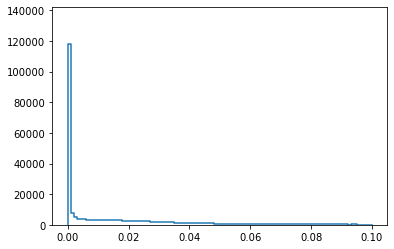

In [6]:
import matplotlib.pyplot as plt
import mplhep as hep             # https://github.com/scikit-hep/mplhep
import boost_histogram as bh     # https://github.com/scikit-hep/boost-histogram

vtx_hist = bh.Histogram(bh.axis.Regular(100, 0, 0.1))

vtx_hist.fill(vtx_dist.flatten())

hep.histplot(vtx_hist)

In [41]:
vtx_dist > 0.01

<JaggedArray [[True True True ... True True True] [False True True ... True True True] [True False True ... True True True] ... [False True True ... False True True] [False False False ... False False True] [True False False ... True True True]] at 0x7f2dd75defd0>

In [42]:
pdg = tree["pdg"].array()
pdg[vtx_dist > 0.01]

<JaggedArray [[11 211 -211 ... 22 22 22] [211 -211 -211 ... -211 22 22] [11 2212 211 ... 22 22 -211] ... [-211 321 -321 ... -211 22 22] [211 -211 211 ... 211 -211 130] [11 2112 -211 ... 130 22 22]] at 0x7f2dd54ed650>

In [43]:
counter = 0
for event in pdg[vtx_dist > 0.10]:
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

16 particles: p pi- K+ pi- pi- pi+ pi- pi+ K(L)0 pi+ pi- pi+ gamma gamma gamma gamma
9 particles: pi- pi+ K(L)0 gamma gamma gamma gamma pi+ pi-
8 particles: pi- pi- K+ K- pi+ gamma gamma pi-
7 particles: nu(mu) mu+ pi+ pi- K- gamma gamma
8 particles: K- pi+ p~ pi+ pi- pi+ K+ pi-
6 particles: gamma gamma gamma gamma gamma gamma
2 particles: K- K(L)0
1 particles: n
0 particles: 
12 particles: K- pi+ pi- K(L)0 pi- pi+ gamma gamma gamma gamma gamma gamma
7 particles: pi+ pi- K(L)0 pi+ K- gamma gamma
10 particles: pi+ pi- nu(e)~ e- K+ K(L)0 gamma gamma gamma gamma
11 particles: n pi+ K- gamma gamma gamma gamma p~ pi+ pi+ pi-
6 particles: K+ pi+ pi- pi- gamma gamma
16 particles: pi- pi- pi+ gamma gamma pi- K- pi+ pi+ pi- gamma gamma gamma gamma gamma gamma
6 particles: K+ pi- gamma gamma gamma gamma
10 particles: pi- pi+ p~ e+ e- gamma gamma gamma gamma gamma
18 particles: n pi- n~ pi+ n pi+ pi- pi+ pi- p pi- n~ pi+ pi+ gamma gamma gamma gamma
11 particles: nu(e) e+ K- K+ pi- pi+ pi- gamma g

In [44]:
Particle.from_string("p~")

<Particle: name="p~", pdgid=-2212, mass=938.272081 ± 0.000006 MeV>

In [45]:
Particle.from_string("p~").pdgid

<PDGID: -2212>

In [46]:
is_antiproton = (pdg == Particle.from_string("p~").pdgid)
is_antiproton

<JaggedArray [[False False False ... False False False] [False False False ... False False False] [False False False ... False False False] ... [False False False ... False False False] [False False False ... False False False] [False False False ... False False False]] at 0x7f2e0c106910>

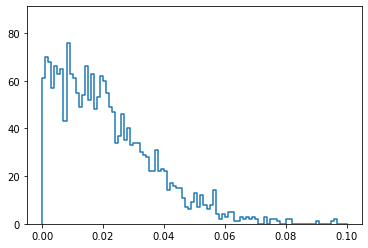

In [47]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 0.1)).fill(
    vtx_dist[is_antiproton].flatten()
))

But that's a topic for the next section.

<br>
<br>
<a name="awkward"></a>
<img src="https://github.com/scikit-hep/awkward-1.0/raw/master/docs-images/logo/logo-600px.png" width="400">

Awkward Array is a library for manipulating arbitrary data structures in a NumPy-like way.

The idea is that you have a large number of identically typed, nested objects in variable-length lists.

<img src="../docs-images/diagrams/cartoon-schematic.png" width="600">

## Using Uproot data in Awkward 1.0

Awkward Array is in transition from

   * version 0.x, which is in use at the LHC but has revealed some design flaws, to
   * version 1.x, which is well-architected and has completed development, but is not in widespread use yet.

Awkward 1.0 hasn't been incorporated into Uproot yet, which is how it will get in front of most users.

Since development is complete and the interface is (intentionally) different, I thought it better to show you the new version.

In [7]:
import awkward1 as ak

Old-style arrays can be converted into the new framework with [ak.from_awkward0](https://awkward-array.readthedocs.io/en/latest/_auto/ak.from_awkward0.html). This won't be a necessary step for long.

In [49]:
?ak.from_awkward0

Signature:
ak.from_awkward0(
    array,
    keeplayout=False,
    regulararray=False,
    highlevel=True,
    behavior=None,
)
Docstring:
Args:
    array (Awkward 0.x or Awkward 1.x array): Data to convert to Awkward
        1.x.
    keeplayout (bool): If True, stay true to the Awkward 0.x layout,
        ensuring zero-copy; otherwise, allow transformations that copy
        data for more flexibility.
    regulararray (bool): If True and the array is multidimensional,
        the dimensions are represented by nested #ak.layout.RegularArray
        nodes; if False and the array is multidimensional, the dimensions
        are represented by a multivalued #ak.layout.NumpyArray.shape.
        If the array is one-dimensional, this has no effect.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.
    behavior (bool): Custom #ak.behavior for the output array, if
        high-level.

Converts an array from Awkward 0.x to Awkwa

In [50]:
?ak.to_awkward0

Signature: ak.to_awkward0(array, keeplayout=False)
Docstring:
Args:
    array: Data to convert into an Awkward 0.x array.
    keeplayout (bool): If True, stay true to the Awkward 1.x layout,
        ensuring zero-copy; otherwise, allow transformations that copy
        data for more flexibility.

Converts `array` (many types supported, including all Awkward Arrays and
Records) into an Awkward 0.x array.

This is only needed during the transition from the old library to the new
library.
File:      ~/irishep/awkward-1.0/awkward1/operations/convert.py
Type:      function


In [51]:
ak.from_awkward0(tree.array("pdg"))

<Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>

In [8]:
arrays = {name: ak.from_awkward0(array) for name, array in tree.arrays(namedecode="utf-8").items()}
arrays

{'evt_id': <Array [0, 1, 2, 3, ... 9996, 9997, 9998, 9999] type='10000 * uint64'>,
 'evt_true_q2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_x': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_y': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_w2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_nu': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_has_dis_info': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * int8'>,
 'evt_prt_count': <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>,
 'evt_weight': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'id': <Array [[12, 79, 80, 81, ... 54, 60, 61, 62]] type='10000 * var * uint64'>,
 'pdg': <Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>,
 'trk_id': <Array [[0, 0, 0, 0, 0, 0,

## Iteration in Python vs array-at-a-time operations

As before, you _can_ iterate over them in Python, but only do that for small-scale exploration.

In [53]:
%%timeit -n1 -r1

vtx_dist = []
for xs, xy, xz in zip(arrays["vtx_x"], arrays["vtx_y"], arrays["vtx_z"]):
    out = []
    for x, y, z in zip(xs, xy, xz):
        out.append(np.sqrt(x**2 + y**2 + z**2))
    vtx_dist.append(out)

11.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [54]:
%%timeit -n100 -r1

vtx_dist = np.sqrt(arrays["vtx_x"]**2 + arrays["vtx_y"]**2 + arrays["vtx_z"]**2)

25.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


## Zipping arrays into records and projecting them back out

Instead of having all these arrays floating around, let's [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) them into a structure.

(This is the sort of thing that a framework developer might do for the data analysts.)

In [55]:
?ak.zip

Signature:
ak.zip(
    arrays,
    depthlimit=None,
    parameters=None,
    with_name=None,
    highlevel=True,
)
Docstring:
Args:
    arrays (dict or iterable of arrays): Arrays to combine into a
        record-containing structure (if a dict) or a tuple-containing
        structure (if any other kind of iterable).
    depthlimit (None or int): If None, attempt to fully broadcast the
        `array` to all levels. If an int, limit the number of dimensions
        that get broadcasted. The minimum value is `1`, for no
        broadcasting.
    parameters (dict): Parameters for the new #ak.layout.RecordArray node
        that is created by this operation.
    with_name (None or str): Assigns a `"__record__"` name to the new
        #ak.layout.RecordArray node that is created by this operation
        (overriding `parameters`, if necessary).
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Combines `arrays` into a si

In [9]:
events = ak.zip({"id": arrays["evt_id"],
                 "true": ak.zip({"q2": arrays["evt_true_q2"],
                                 "x": arrays["evt_true_x"],
                                 "y": arrays["evt_true_y"],
                                 "w2": arrays["evt_true_w2"],
                                 "nu": arrays["evt_true_nu"]}),
                 "has_dis_info": arrays["evt_has_dis_info"],
                 "prt_count": arrays["evt_prt_count"],
                 "prt": ak.zip({"id": arrays["id"],
                                "pdg": arrays["pdg"],
                                "trk_id": arrays["trk_id"],
                                "charge": arrays["charge"],
                                "dir": ak.zip({"x": arrays["dir_x"],
                                               "y": arrays["dir_y"],
                                               "z": arrays["dir_z"]}, with_name="point3"),
                                "p": arrays["p"],
                                "px": arrays["px"],
                                "py": arrays["py"],
                                "pz": arrays["pz"],
                                "m": arrays["m"],
                                "time": arrays["time"],
                                "is_beam": arrays["is_beam"],
                                "is_stable": arrays["is_stable"],
                                "gen_code": arrays["gen_code"],
                                "mother": ak.zip({"id": arrays["mother_id"],
                                                  "second_id": arrays["mother_second_id"]}),
                                "pol": ak.zip({"has_info": arrays["has_pol_info"],
                                               "x": arrays["pol_x"],
                                               "y": arrays["pol_y"],
                                               "z": arrays["pol_z"]}, with_name="point3"),
                                "vtx": ak.zip({"has_info": arrays["has_vtx_info"],
                                               "id": arrays["vtx_id"],
                                               "x": arrays["vtx_x"],
                                               "y": arrays["vtx_y"],
                                               "z": arrays["vtx_z"],
                                               "t": arrays["vtx_t"]}, with_name="point3"),
                                "smear": ak.zip({"has_info": arrays["has_smear_info"],
                                                 "has_e": arrays["smear_has_e"],
                                                 "has_p": arrays["smear_has_p"],
                                                 "has_pid": arrays["smear_has_pid"],
                                                 "has_vtx": arrays["smear_has_vtx"],
                                                 "has_any_eppid": arrays["smear_has_any_eppid"],
                                                 "orig": ak.zip({"tot_e": arrays["smear_orig_tot_e"],
                                                                 "p": arrays["smear_orig_p"],
                                                                 "px": arrays["smear_orig_px"],
                                                                 "py": arrays["smear_orig_py"],
                                                                 "pz": arrays["smear_orig_pz"],
                                                                 "vtx": ak.zip({"x": arrays["smear_orig_vtx_x"],
                                                                                "y": arrays["smear_orig_vtx_y"],
                                                                                "z": arrays["smear_orig_vtx_z"]},
                                                                               with_name="point3")})})}, with_name="particle")},
                depthlimit=1)

In [57]:
?ak.type

Signature: ak.type(array)
Docstring:
The high-level type of an `array` (many types supported, including all
Awkward Arrays and Records) as #ak.types.Type objects.

The high-level type ignores #layout differences like
#ak.layout.ListArray64 versus #ak.layout.ListOffsetArray64, but
not differences like "regular-sized lists" (i.e.
#ak.layout.RegularArray) versus "variable-sized lists" (i.e.
#ak.layout.ListArray64 and similar).

Types are rendered as [Datashape](https://datashape.readthedocs.io/)
strings, which makes the same distinctions.

For example,

    ak.Array([[{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [2, 2]}],
              [],
              [{"x": 3.3, "y": [3, 3, 3]}]])

has type

    3 * var * {"x": float64, "y": var * int64}

but

    ak.Array(np.arange(2*3*5).reshape(2, 3, 5))

has type

    2 * 3 * 5 * int64

Some cases, like heterogeneous data, require [extensions beyond the
Datashape specification](https://github.com/blaze/datashape/issues/237).
For example,

    ak.Array([1,

In [10]:
ak.type(events)

10000 * {"id": uint64, "true": {"q2": float64, "x": float64, "y": float64, "w2": float64, "nu": float64}, "has_dis_info": int8, "prt_count": uint64, "prt": var * particle["id": uint64, "pdg": int64, "trk_id": float64, "charge": float64, "dir": point3["x": float64, "y": float64, "z": float64], "p": float64, "px": float64, "py": float64, "pz": float64, "m": float64, "time": float64, "is_beam": bool, "is_stable": bool, "gen_code": bool, "mother": {"id": uint64, "second_id": uint64}, "pol": point3["has_info": float64, "x": float64, "y": float64, "z": float64], "vtx": point3["has_info": bool, "id": uint64, "x": float64, "y": float64, "z": float64, "t": float64], "smear": {"has_info": bool, "has_e": bool, "has_p": bool, "has_pid": bool, "has_vtx": bool, "has_any_eppid": bool, "orig": {"tot_e": float64, "p": float64, "px": float64, "py": float64, "pz": float64, "vtx": point3["x": float64, "y": float64, "z": float64]}}]}

The type written with better formatting:

```javascript
10000 * {"id": uint64,
         "true": {"q2": float64,
                  "x": float64,
                  "y": float64,
                  "w2": float64,
                  "nu": float64},
         "has_dis_info": int8,
         "prt_count": uint64,

         "prt": var * particle["id": uint64,
                               "pdg": int64,
                               "trk_id": float64,
                               "charge": float64,
                               "dir": point3["x": float64, "y": float64, "z": float64],
                               "p": float64,
                               "px": float64,
                               "py": float64,
                               "pz": float64,
                               "m": float64,
                               "time": float64,
                               "is_beam": bool,
                               "is_stable": bool,
                               "gen_code": bool,
                               "mother": {"id": uint64, "second_id": uint64},
                               "pol": point3["has_info": float64,
                                             "x": float64,
                                             "y": float64,
                                             "z": float64],
                               "vtx": point3["has_info": bool,
                                             "id": uint64,
                                             "x": float64,
                                             "y": float64,
                                             "z": float64,
                                             "t": float64],
                               "smear": {"has_info": bool,
                                         "has_e": bool,
                                         "has_p": bool,
                                         "has_pid": bool,
                                         "has_vtx": bool,
                                         "has_any_eppid": bool,
                                         "orig": {"tot_e":
                                                  float64,
                                                  "p": float64,
                                                  "px": float64,
                                                  "py": float64,
                                                  "pz": float64,
                                                  "vtx": point3["x": float64,
                                                                "y": float64,
                                                                "z": float64]}}]}
```

It means that these are now nested objects.

In [59]:
?ak.to_list

Signature: ak.to_list(array)
Docstring:
Converts `array` (many types supported, including all Awkward Arrays and
Records) into Python objects.

Awkward Array types have the following Pythonic translations.

   * #ak.types.PrimitiveType: converted into bool, int, float.
   * #ak.types.OptionType: missing values are converted into None.
   * #ak.types.ListType: converted into list.
   * #ak.types.RegularType: also converted into list. Python (and JSON)
     forms lose information about the regularity of list lengths.
   * #ak.types.ListType with parameter `"__array__"` equal to
     `"__bytestring__"`: converted into bytes.
   * #ak.types.ListType with parameter `"__array__"` equal to
     `"__string__"`: converted into str.
   * #ak.types.RecordArray without field names: converted into tuple.
   * #ak.types.RecordArray with field names: converted into dict.
   * #ak.types.UnionArray: Python data are naturally heterogeneous.

See also #ak.from_iter and #ak.Array.tolist.
File:      ~/iris

In [60]:
ak.to_list(events[0].prt[0])

{'id': 12,
 'pdg': 11,
 'trk_id': 0.0,
 'charge': -1.0,
 'dir': {'x': 0.027552974158427224,
  'y': -0.159486986156017,
  'z': 0.9868154512683186},
 'p': 3.2559399993304847,
 'px': -0.5164342370904987,
 'py': 0.08917945577907008,
 'pz': 3.2134853325739483,
 'm': 0.0,
 'time': 0.0,
 'is_beam': False,
 'is_stable': False,
 'gen_code': False,
 'mother': {'id': 0, 'second_id': 0},
 'pol': {'has_info': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0},
 'vtx': {'has_info': True,
  'id': 0,
  'x': -0.0002629100828319597,
  'y': 0.008004273764408541,
  'z': 0.007348471013211623,
  't': 0.0},
 'smear': {'has_info': True,
  'has_e': True,
  'has_p': True,
  'has_pid': False,
  'has_vtx': True,
  'has_any_eppid': True,
  'orig': {'tot_e': 3.2399370783466463,
   'p': 3.239937038049433,
   'px': 0.08926990148430726,
   'py': -0.5167277935337566,
   'pz': 3.1972199302836906,
   'vtx': {'x': 0.0, 'y': 0.0, 'z': 0.0}}}}

In [61]:
ak.to_list(events[-1].prt[:10].smear.orig.vtx)

[{'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': -6.110853575363856e-12,
  'y': -2.4888797620237205e-12,
  'z': -1.0095678734711646e-10},
 {'x': -7.214024530021195e-12,
  'y': -2.801047134360359e-12,
  'z': -1.0233975313075053e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -2.1591646092697467, 'y': 0.9341721743864254, 'z': -527.4931103722447},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04451351075293813,
  'y': -0.013705013997490656,
  'z': -0.36581179515431195}]

Alternatively,

In [62]:
ak.to_list(events[-1, "prt", :10, "smear", "orig", "vtx"])

[{'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': -6.110853575363856e-12,
  'y': -2.4888797620237205e-12,
  'z': -1.0095678734711646e-10},
 {'x': -7.214024530021195e-12,
  'y': -2.801047134360359e-12,
  'z': -1.0233975313075053e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -2.1591646092697467, 'y': 0.9341721743864254, 'z': -527.4931103722447},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04451351075293813,
  'y': -0.013705013997490656,
  'z': -0.36581179515431195}]

<img src="../docs-images/diagrams/how-it-works-muons.png" width="1000">

"Zipping" arrays together into structures costs nothing (time does not scale with size of data), nor does "projecting" arrays out of structures.

In [63]:
events.prt.px

<Array [[-0.516, -0.246, ... -0.0205, -0.377]] type='10000 * var * float64'>

In [64]:
events.prt.py

<Array [[0.0892, 0.548, ... 0.0232, 0.043]] type='10000 * var * float64'>

In [65]:
events.prt.pz

<Array [[3.21, -2.11, ... -0.0904, -3.02]] type='10000 * var * float64'>

This is called "projection" because the request for `"pz"` is slicing through arrays and jagged arrays.

The following are equivalent:

In [66]:
events[999, "prt", 12, "pz"]

-1.2469826742751766

In [67]:
events["prt", 999, 12, "pz"]

-1.2469826742751766

In [68]:
events[999, "prt", "pz", 12]

-1.2469826742751766

In [69]:
events["prt", 999, "pz", 12]

-1.2469826742751766

This "object oriented view" is a conceptual aid, not a constraint on computation. It's very fluid.

Moreover, we can add behaviors to named records, like methods in object oriented programming. (See [ak.behavior](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html) in the documentation.)

(This is the sort of thing that a framework developer might do for the data analysts.)

In [11]:
def point3_absolute(data):
    return np.sqrt(data.x**2 + data.y**2 + data.z**2)

def point3_distance(left, right):
    return np.sqrt((left.x - right.x)**2 + (left.y - right.y)**2 + (left.z - right.z)**2)

ak.behavior[np.absolute, "point3"] = point3_absolute
ak.behavior[np.subtract, "point3", "point3"] = point3_distance

In [71]:
# Absolute value of all smear origin vertexes
abs(events.prt.smear.orig.vtx)

<Array [[0, 2.34e-10, ... 0.369, 0.369]] type='10000 * var * float64'>

In [72]:
# Absolute value of the last smear origin vertex
abs(events[-1].prt[-1].smear.orig.vtx)

0.3687648973563558

In [73]:
# Distance between each particle vertex and itself
events.prt.vtx - events.prt.vtx

<Array [[0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0]] type='10000 * var * float64'>

In [74]:
# Distances between the first and last particle vertexes in the first 100 events
events.prt.vtx[:100, 0] - events.prt.vtx[:100, -1]

<Array [3.18, 0.0284, 0.554, ... 45.1, 0.142] type='100 * float64'>

More methods can be added by declaring subclasses of arrays and records.

In [12]:
class ParticleRecord(ak.Record):    
    @property
    def pt(self):
        return np.sqrt(self.px**2 + self.py**2)

class ParticleArray(ak.Array):
    __name__ = "Array"   # prevent it from writing <ParticleArray [...] type='...'>
                         # instead of              <Array [...] type='...'>
    @property
    def pt(self):
        return np.sqrt(self.px**2 + self.py**2)

ak.behavior["particle"] = ParticleRecord
ak.behavior["*", "particle"] = ParticleArray

In [31]:
type(events[0].prt[0])

__main__.ParticleRecord

In [32]:
events[0].prt[0]

<ParticleRecord ... vtx: {x: 0, y: 0, z: 0}}}} type='particle["id": uint64, "pdg...'>

In [33]:
events[0].prt[0].pt

0.5240775673240523

In [34]:
type(events.prt)

__main__.ParticleArray

In [35]:
events.prt

<Array [[{id: 12, pdg: 11, trk_id: 0, ... ] type='10000 * var * particle["id": u...'>

In [36]:
events.prt.pt

<Array [[0.524, 0.601, 0.72, ... 0.031, 0.38]] type='10000 * var * float64'>

## Filtering (cutting) events and particles with advanced selections

NumPy has a versatile selection mechanism:

<img src="https://raw.githubusercontent.com/jpivarski/2019-07-23-codas-hep/master/img/numpy-slicing.png" width="300">

The same expressions apply to Awkward Arrays, and more.

In [75]:
# First particle momentum in the first 5 events
events.prt.p[:5, 0]

<Array [3.26, 15.8, 17.9, 14.5, 7.33] type='5 * float64'>

In [76]:
# First two particles in all events
events.prt.pdg[:, :2]

<Array [[11, 211], [11, ... 2112], [11, -211]] type='10000 * var * int64'>

In [77]:
# First direction of the last event
events.prt.dir[-1, 0]

<Record {x: 0.0809, y: 0.0151, z: 0.997} type='point3["x": float64, "y": float64...'>

NumPy also lets you filter (cut) using an array of booleans.

In [78]:
events.prt_count > 100

<Array [False, False, False, ... False, False] type='10000 * bool'>

In [79]:
np.count_nonzero(events.prt_count > 100)

16

In [80]:
events[events.prt_count > 100]

<Array [{id: 734, true: {q2: 0, x: 0, ... ] type='16 * {"id": uint64, "true": {"...'>

One dimension can be selected with an array while another is selected with a slice.

In [81]:
# Select events with at least two particles, then select the first two particles
events.prt[events.prt_count >= 2, :2]

<Array [[{id: 12, pdg: 11, trk_id: 0, ... ] type='9963 * var * {"id": uint64, "p...'>

This can be a good way to avoid errors from trying to select what isn't there.

In [82]:
try:
    events.prt[:, 0]
except Exception as err:
    print(type(err).__name__, str(err))

ValueError in ListArray64 attempting to get 0, index out of range


In [83]:
events.prt[events.prt_count > 0, 0]

<Array [{id: 12, pdg: 11, trk_id: 0, ... ] type='9964 * {"id": uint64, "pdg": in...'>

See also [awkward-array.readthedocs.io](https://awkward-array.readthedocs.io/) for a list of operations like [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html):

In [84]:
?ak.num

Signature: ak.num(array, axis=1, highlevel=True)
Docstring:
Args:
    array: Data containing nested lists to count.
    axis (int): The dimension at which this operation is applied. The
        outermost dimension is `0`, followed by `1`, etc., and negative
        values count backward from the innermost: `-1` is the innermost
        dimension, `-2` is the next level up, etc.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns an array of integers specifying the number of elements at a
particular level.

For instance, given the following doubly nested `array`,

    ak.Array([[
               [1.1, 2.2, 3.3],
               [],
               [4.4, 5.5],
               [6.6]
              ],
              [],
              [
               [7.7],
               [8.8, 9.9]]
              ])

The number of elements in `axis=1` is

    >>> ak.num(array, axis=1)
    <Array [4, 0, 2] type='3 * int64'>

and the numb

In [85]:
ak.num(events.prt), events.prt_count

(<Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * int64'>,
 <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>)

You can even use an array of integers to select a set of indexes at once.

In [86]:
# First and last particle in each event that has at least two
events.prt.pdg[ak.num(events.prt) >= 2][:, [0, -1]]

<Array [[11, 22], [11, 22, ... 130], [11, 22]] type='9963 * 2 * int64'>

But beyond NumPy, we can also use arrays of nested lists as boolean or integer selectors.

In [87]:
# Array of lists of True and False
abs(events.prt.vtx) > 0.10

<Array [[False, False, False, ... True, True]] type='10000 * var * bool'>

In [88]:
# Particles that have vtx > 0.10 for all events (notice that there's still 10000)
events.prt[abs(events.prt.vtx) > 0.10]

<Array [[{id: 125, pdg: 2212, ... ] type='10000 * var * {"id": uint64, "pdg": in...'>

See [awkward-array.readthedocs.io](https://awkward-array.readthedocs.io/) for more, but there are functions like [ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html), which picks the maximum in a groups.

   * With `axis=0`, the group is the set of all events.
   * With `axis=1`, the groups are particles in each event.

In [89]:
?ak.max

Signature: ak.max(array, axis=None, keepdims=False, mask_identity=True)
Docstring:
Args:
    array: Data to maximize.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer descreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    mask_identity (bool): If True, reducing over empty lists results in
        None (an option type); otherwise, reducing over empty lists
        results in the operation's identity.

Returns the maximum value in each group of elements from `array` (many
types supported, including all Awkwar

In [90]:
ak.max(abs(events.prt.vtx), axis=1)

<Array [889, 132, 1.26, ... 15.5, 39.7, 527] type='10000 * ?float64'>

In [91]:
# Selects *events* that have a maximum *particle vertex* greater than 100
events[ak.max(abs(events.prt.vtx), axis=1) > 100]

<Array [{id: 0, true: {q2: 0, x: 0, ... ] type='5535 * ?{"id": uint64, "true": {...'>

The difference between "select particles" and "select events" is the number of jagged dimensions in the array; "reducers" like ak.max reduce the dimensionality by one.

There are other reducers like ak.any, ak.all, ak.sum...

In [92]:
?ak.sum

Signature: ak.sum(array, axis=None, keepdims=False, mask_identity=False)
Docstring:
Args:
    array: Data to sum over.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer descreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    mask_identity (bool): If True, reducing over empty lists results in
        None (an option type); otherwise, reducing over empty lists
        results in the operation's identity.

Sums over `array` (many types supported, including all Awkward Arrays
and Records). The identity of additio

In [93]:
# Is this particle an antineutron?
events.prt.pdg == Particle.from_string("n~").pdgid

<Array [[False, False, ... False, False]] type='10000 * var * bool'>

In [94]:
# Are any particles in the event antineutrons?
ak.any(events.prt.pdg == Particle.from_string("n~").pdgid, axis=1)

<Array [False, True, False, ... False, False] type='10000 * bool'>

In [95]:
# Select events that contain an antineutron
events[ak.any(events.prt.pdg == Particle.from_string("n~").pdgid, axis=1)]

<Array [{id: 1, true: {q2: 0, x: 0, ... ] type='4130 * {"id": uint64, "true": {"...'>

We can use these techniques to make subcollections for specific particle types and attach them to the same `events` array for easy access.

In [96]:
events.prt[abs(events.prt.pdg) == abs(Particle.from_string("p").pdgid)]

<Array [[{id: 125, pdg: 2212, ... [], []] type='10000 * var * {"id": uint64, "pd...'>

In [13]:
# Assignments have to be through __setitem__ (brackets), not __setattr__ (as an attribute).
# Is that a problem? (Assigning as an attribute would have to be implemented with care, if at all.)

events["pions"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("pi+").pdgid)]
events["kaons"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("K+").pdgid)]
events["protons"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("p").pdgid)]

In [38]:
events.pions

<Array [[{id: 79, pdg: 211, ... ] type='10000 * var * particle["id": uint64, "pd...'>

In [39]:
events.kaons

<Array [[{id: 81, pdg: -321, ... ] type='10000 * var * particle["id": uint64, "p...'>

In [40]:
events.protons

<Array [[{id: 125, pdg: 2212, ... [], []] type='10000 * var * particle["id": uin...'>

In [41]:
ak.num(events.prt), ak.num(events.pions), ak.num(events.kaons), ak.num(events.protons)

(<Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * int64'>,
 <Array [23, 8, 13, 8, 12, ... 19, 11, 14, 9, 3] type='10000 * int64'>,
 <Array [6, 0, 2, 1, 2, 0, ... 6, 3, 1, 4, 2, 1] type='10000 * int64'>,
 <Array [1, 0, 1, 1, 1, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * int64'>)

## Flattening for plots and regularizing to NumPy for machine learning

All of this structure is great, but eventually, we need to plot the data or ship it to some statistical process, such as machine learning.

Most of these tools know about NumPy arrays and rectilinear data, but not Awkward Arrays.

As a design choice, Awkward Array **does not implicitly flatten**; you need to do this yourself, and you might make different choices of how to apply this lossy transformation in different circumstances.

The basic tool for removing structure is [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html).

In [102]:
?ak.flatten

Signature: ak.flatten(array, axis=1, highlevel=True)
Docstring:
Args:
    array: Data containing nested lists to flatten.
    axis (None or int): If None, the operation flattens all levels of
        nesting, returning a 1-dimensional array. Otherwise, it flattens
        at a specified depth. The outermost dimension is `0`, followed
        by `1`, etc., and negative values count backward from the
        innermost: `-1` is the innermost dimension, `-2` is the next
        level up, etc.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns an array with one level of nesting removed by erasing the
boundaries between consecutive lists. Since this operates on a level of
nesting, `axis=0` is invalid.

Consider the following doubly nested `array`.

    ak.Array([[
               [1.1, 2.2, 3.3],
               [],
               [4.4, 5.5],
               [6.6]],
              [],
              [
               [7.7

In [14]:
# Turn particles-grouped-by-event into one big array of particles
ak.flatten(events.prt, axis=1)

<Array [{id: 12, pdg: 11, trk_id: 0, ... ] type='349274 * particle["id": uint64,...'>

In [15]:
# Eliminate structure at all levels; produce one numerical array
ak.flatten(events.prt, axis=None)

<Array [12, 79, 80, ... -0.365, -0.366, -0.366] type='14669508 * float64'>

For plotting, you probably want to pick one field and flatten it. Flattening with `axis=1` (the default) works for one level of structure and is safer than `axis=None`.

(array([ 2680.,  8269., 10827., 10533.,  9300.,  7937.,  6671.,  5698.,
         4828.,  4188.,  3729.,  3191.,  2851.,  2666.,  2376.,  2210.,
         1931.,  1828.,  1723.,  1493.,  1392.,  1361.,  1220.,  1170.,
         1085.,   949.,   941.,   929.,   805.,   779.,   732.,   701.,
          677.,   625.,   586.,   520.,   545.,   488.,   429.,   411.,
          377.,   411.,   380.,   366.,   321.,   295.,   320.,   306.,
          274.,   257.,   254.,   223.,   198.,   191.,   195.,   177.,
          203.,   173.,   193.,   164.,   144.,   157.,   140.,   130.,
          101.,   114.,   105.,   111.,    88.,   101.,    96.,    96.,
           94.,    70.,    87.,    60.,    81.,    63.,    77.,    52.,
           60.,    57.,    55.,    50.,    44.,    48.,    51.,    45.,
           43.,    44.,    32.,    32.,    37.,    33.,    44.,    29.,
           31.,    31.,    23.,    29.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2, 

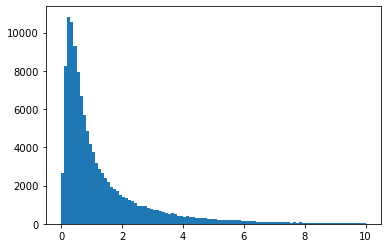

In [16]:
# Directly through Matplotlib
plt.hist(ak.flatten(events.pions.p), bins=100, range=(0, 10))

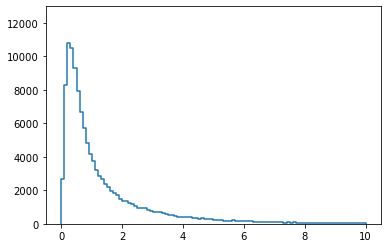

In [17]:
# Through mplhep and boost-histgram, which are more HEP-friendly

hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    ak.flatten(events.pions.p)
    
))

If the particles are sorted (`ak.sort`/`ak.argsort` is [in development](https://github.com/scikit-hep/awkward-1.0/pull/168)), you might want to pick the first pion from every event that has them (i.e. *use* the event structure).

This is an analysis choice: *you* have to decide you want this.

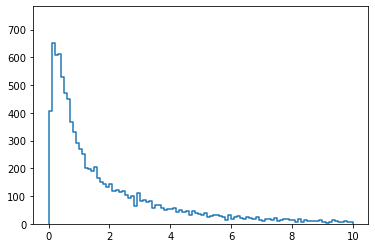

In [18]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    events.pions.p[ak.num(events.pions) > 0, 0]
    
))

Or perhaps the maximum pion momentum in each event.

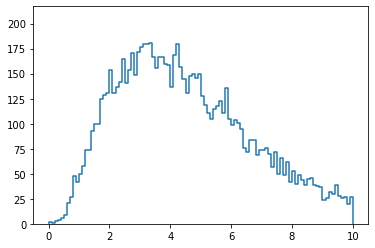

In [19]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    ak.max(events.pions.p, axis=1)   # axis=1 means maximize per event
    
))

Or perhaps the momentum of the pion with the farthest vertex. [ak.argmax](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmax.html) creates an array of integers selecting from each event.

In [45]:
?ak.argmax

Signature: ak.argmax(array, axis=None, keepdims=False, mask_identity=True)
Docstring:
Args:
    array: Data to find the index positions of the maximum values.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer descreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    mask_identity (bool): If True, reducing over empty lists results in
        None (an option type); otherwise, reducing over empty lists
        results in the operation's identity.

Returns the index position of the maximum value in each group of el

In [20]:
ak.argmax(abs(events.pions.vtx), axis=1)

<Array [21, 6, 7, 7, 7, ... 18, 8, 10, 8, 1] type='10000 * ?int64'>

In [23]:
?ak.singletons

Signature: ak.singletons(array, highlevel=True)
Docstring:
Args:
    array: Data to wrap in lists of length 1 if present and length 0
        if missing (None).
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns a singleton list (length 1) wrapping each non-missing value and
an empty list (length 0) in place of each missing value.

For example,

    >>> array = ak.Array([1.1, 2.2, None, 3.3, None, None, 4.4, 5.5])
    >>> print(ak.singletons(array))
    [[1.1], [2.2], [], [3.3], [], [], [4.4], [5.5]]
File:      ~/irishep/awkward-1.0/awkward1/operations/structure.py
Type:      function


In [22]:
# Get a length-1 list containing the index of the biggest vertex when there is one
# And a length-0 list when there isn't one
ak.singletons(ak.argmax(abs(events.pions.vtx), axis=1))

<Array [[21], [6], [7], ... [10], [8], [1]] type='10000 * var * int64'>

In [24]:
# A nested integer array like this is what we need to select pions with the biggest vertex
events.pions[ak.singletons(ak.argmax(abs(events.pions.vtx), axis=1))]

<Array [[{id: 160, pdg: -211, ... ] type='10000 * var * particle["id": uint64, "...'>

In [26]:
events.pions[ak.singletons(ak.argmax(abs(events.pions.vtx), axis=1))].p

<Array [[2.06], [0.416], ... [0.389], [6.66]] type='10000 * var * float64'>

In [27]:
# Flatten the distinction between length-1 lists and length-0 lists
ak.flatten(events.pions[ak.singletons(ak.argmax(abs(events.pions.vtx), axis=1))].p)

<Array [2.06, 0.416, 1.64, ... 0.389, 6.66] type='9890 * float64'>

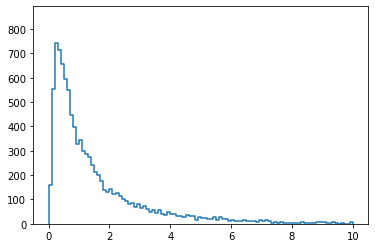

In [25]:
# Putting it all together...
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    ak.flatten(events.pions[ak.singletons(ak.argmax(abs(events.pions.vtx), axis=1))].p)
    
))

## Broadcasting flat arrays and jagged arrays

## Combinatorics: cartesian and combinations

In [ ]:
piplus = events.prt[(events.prt.pdg == Particle.from_string("pi+").pdgid) & (abs(events.prt.vtx) > 0.03)]
piminus = events.prt[(events.prt.pdg == Particle.from_string("pi-").pdgid) & (abs(events.prt.vtx) > 0.03)]

In [ ]:
def mass(pair, left_mass, right_mass):
    left, right = ak.unzip(pair)
    left_energy = np.sqrt(left.p**2 + left_mass**2)
    right_energy = np.sqrt(right.p**2 + right_mass**2)
    return np.sqrt((left_energy + right_energy)**2 -
                   (left.px + right.px)**2 -
                   (left.py + right.py)**2 -
                   (left.pz + right.pz)**2)

In [ ]:
pairwise_masses = mass(ak.cartesian([piplus, piminus]), 0.139570, 0.139570)
pairwise_masses

In [ ]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.497611 - 0.015, 0.497611 + 0.015)).fill(
    ak.flatten(pairwise_masses)
))

In [ ]:
kminus = events.prt[(events.prt.pdg == Particle.from_string("K-").pdgid) & (abs(events.prt.vtx) > 0.10)]
piplus = events.prt[(events.prt.pdg == Particle.from_string("pi+").pdgid) & (abs(events.prt.vtx) > 0.10)]

pairwise_masses = mass(ak.cartesian([kminus, piplus]), 0.493677, 0.139570)
pairwise_masses

hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.8, 2)).fill(
    ak.flatten(pairwise_masses)
))

In [ ]:
proton = events.prt[(events.prt.pdg == Particle.from_string("p").pdgid) & (abs(events.prt.vtx) > 0.10)]
piminus = events.prt[(events.prt.pdg == Particle.from_string("pi-").pdgid) & (abs(events.prt.vtx) > 0.10)]

pairwise_masses = mass(ak.cartesian([proton, piminus]), 0.938272, 0.139570)
pairwise_masses

hep.histplot(bh.Histogram(bh.axis.Regular(100, 1.115683 - 0.01, 1.115683 + 0.01)).fill(
    ak.flatten(pairwise_masses)
))

## Reducing from combinations

## Imperative, but still fast, programming in Numba

## Grafting jagged data onto Pandas

## NumExpr, Autograd, and other third-party libraries